In [1]:
pwd

'/mmfs1/data/aglinska/BC-CVAE-MRI-ASD-PUB/Notebooks'

In [2]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

2022-06-14 09:46:05.701876


In [3]:
# GPU checks
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# GPU checks
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# GPU checks
!nvidia-smi

Tue Jun 14 09:46:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   33C    P0    58W / 300W |    456MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [7]:
%matplotlib inline

from importlib import reload
from helper_funcs import *
from make_models2 import *

# Make tqdm work for notebooks
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import pickle
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


print(now()-t00)

0:01:07.732909


In [8]:
# Run GPU test
import tensorflow as tf
import timeit,pickle

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.19237444270402193
GPU (s):
0.031616211868822575
GPU speedup over CPU: 6x


In [19]:
# LOAD Data
arr = np.load('../Data/ABIDE-Anat-64iso-S982_v2.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
print([arr.shape for arr in [ABIDE_subs,ABIDE_data]])
print((ABIDE_data.min(),ABIDE_data.max()))

[(982,), (982, 64, 64, 64)]
(0.0, 1.0)


In [22]:
# Load Data Legend
df = pd.read_csv('../Data/ABIDE_legend_S982.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)
print(df.shape)

assert len(df)==len(ABIDE_subs),'lenght mismatch'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'order mismatch'

df

(982, 91)


,level_0,Unnamed: 0,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,...,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID
0,0,0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
1,1,1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
2,2,2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
3,3,3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
4,4,4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,977,977,1094,sub-985,A00032725,CONTROL,session_1,28,51252,2,...,NaN,10.99,0.0,NaN,NaN,NaN,ucla,triotim,6,12
978,978,978,1095,sub-986,A00032704,PATIENT,session_1,28,51229,1,...,NaN,14.59,0.0,NaN,NaN,NaN,ucla,triotim,6,12
979,979,979,1096,sub-987,A00032740,CONTROL,session_1,28,51268,2,...,NaN,17.78,0.0,NaN,NaN,NaN,ucla,triotim,6,12
980,980,980,1098,sub-989,A00032686,PATIENT,session_1,28,51210,1,...,NaN,16.56,0.0,NaN,NaN,NaN,ucla,triotim,6,12


In [23]:
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

TD_subs = ABIDE_data[controls,:,:,:] # Data of Typically Developing participants 
DX_subs = ABIDE_data[patients,:,:,:] # Data of ASD participants

print(TD_subs.shape)
print(DX_subs.shape)

(512, 64, 64, 64)
(470, 64, 64, 64)


### TRAIN VAE

In [24]:
train_vae = True

In [25]:
if train_vae:
    
    latent_dim = 32
    batch_size = 16
    disentangle = False
    gamma = 100

    encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64,64,64,1), 
                                            latent_dim=32, 
                                            batch_size = batch_size, 
                                            disentangle=True,
                                            gamma=gamma,
                                            kernel_size = 3,
                                            filters = 48,
                                            intermediate_dim = 128,
                                            nlayers = 2,
                                            bias=True)


    loss = list()
    fn = '../../tf_outputs/VAE/VAE_weights'
        
    print(fn)

../../tf_outputs/VAE/VAE_weights


In [26]:
encoder.summary(line_length=100)

Model: "encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
encoder_input (InputLayer)       [(None, 64, 64, 64, 1 0                                            
____________________________________________________________________________________________________
conv3d_2 (Conv3D)                (None, 32, 32, 32, 96 2688        encoder_input[0][0]              
____________________________________________________________________________________________________
conv3d_3 (Conv3D)                (None, 16, 16, 16, 19 497856      conv3d_2[0][0]                   
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 786432)        0           conv3d_3[0][0]                   
__________________________________________________________________________

In [27]:
decoder.summary(line_length=100)

Model: "decoder"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
z_sampling (InputLayer)                      [(None, 32)]                            0              
____________________________________________________________________________________________________
dense_5 (Dense)                              (None, 128)                             4224           
____________________________________________________________________________________________________
dense_6 (Dense)                              (None, 786432)                          101449728      
____________________________________________________________________________________________________
reshape_1 (Reshape)                          (None, 16, 16, 16, 192)                 0              
__________________________________________________________________________

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

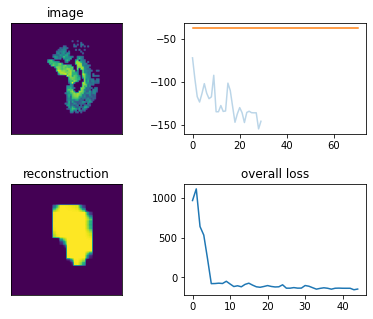

100%|██████████| 49/49 [00:33<00:00,  1.44it/s]


In [28]:
nbatches = 50
if train_vae:
    for i in tqdm(range(1,nbatches)):    
        
        batch_idx = np.random.randint(low=0,high=ABIDE_data.shape[0],size=batch_size)
        data_batch = ABIDE_data[batch_idx,:,:,:]
        
        history = vae.train_on_batch(data_batch);
        mse = ((data_batch-vae.predict(data_batch)[:,:,:,:,0])**2).mean()
        loss.append(history);
        
        if np.mod(i,5)==0: # Plot training progress
            im1 = data_batch[0,32,:,:];
            im = vae.predict(data_batch)[0,32,:,:,0];
            plot_trainProgress(loss,im,im1);

        if np.mod(i,100)==0: # Save every 100 batches
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            vae.save_weights(fn)    
        
        if mse < .005:
            break

### TRAIN CVAE

In [35]:
train_cvae = True

In [36]:
if train_cvae:
    
    latent_dim = 16
    batch_size = 16
    beta = 1;gamma = 100
    disentangle = True
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
    loss = list()    
    
    fdir = '../../tf_outputs/CVAE/'
    fn = 'CVAE_weights'
    
    fn = os.path.join(fdir,fn)
    loss = []

In [37]:
z_encoder.summary(line_length=100)

Model: "z_encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
tg_inputs (InputLayer)           [(None, 64, 64, 64, 1 0                                            
____________________________________________________________________________________________________
conv3d_8 (Conv3D)                (None, 32, 32, 32, 64 1792        tg_inputs[0][0]                  
____________________________________________________________________________________________________
conv3d_9 (Conv3D)                (None, 16, 16, 16, 12 221312      conv3d_8[0][0]                   
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 524288)        0           conv3d_9[0][0]                   
________________________________________________________________________

In [38]:
cvae_decoder.summary(line_length=100)

Model: "decoder"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
z_sampling (InputLayer)                      [(None, 32)]                            0              
____________________________________________________________________________________________________
dense_15 (Dense)                             (None, 128)                             4224           
____________________________________________________________________________________________________
dense_16 (Dense)                             (None, 524288)                          67633152       
____________________________________________________________________________________________________
reshape_3 (Reshape)                          (None, 16, 16, 16, 128)                 0              
__________________________________________________________________________

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

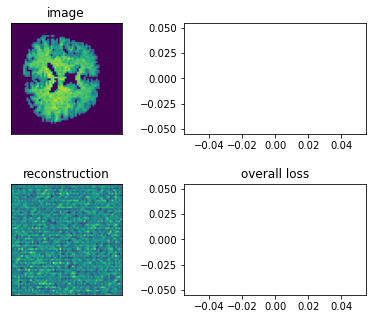

In [39]:
# initial check
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];

if len(loss)==0:
    loss.append(np.nan)
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);
    loss = list()
else:
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

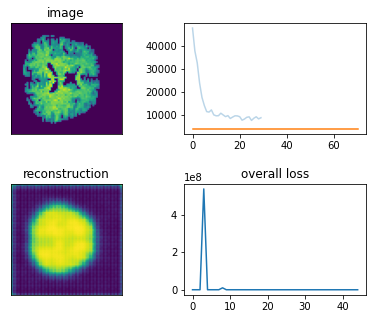

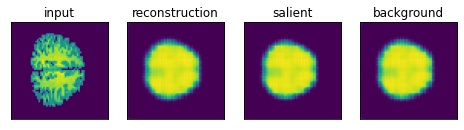

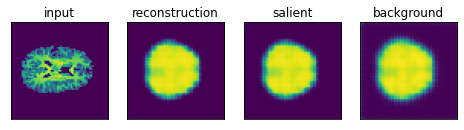

100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


In [40]:
nbatches = 50
if train_cvae:
    for i in tqdm(range(1,nbatches)):
        
        DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
        TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
        
        hist = cvae.train_on_batch([DX_batch,TD_batch]);
        loss.append(hist);
        
        mse = ((np.array([DX_batch,TD_batch])-np.array(cvae.predict([DX_batch,TD_batch]))[:,:,:,:,:,0])**2).mean()

        assert not np.isnan(hist),'loss is NaN - somethings wrong'

        im,im1,ss = cvae_query(ABIDE_data, s_encoder, z_encoder, cvae_decoder); 

        

        if np.mod(i,5)==0: # Plot training progress
            plot_trainProgress(loss,im,im1);
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)

        if np.mod(i,101)==0: # Save every 100 batches
            cvae.save_weights(fn)
            
        if mse < .005:
            break